In [21]:
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import json
import os

In [2]:
con = psycopg2.connect(dbname='gdelt_analysis', user='postgres', password='postgres', host='localhost')
cur = con.cursor()

## Number of Articles for the Terms "Black" & "Hate" Over the Past 3 Years

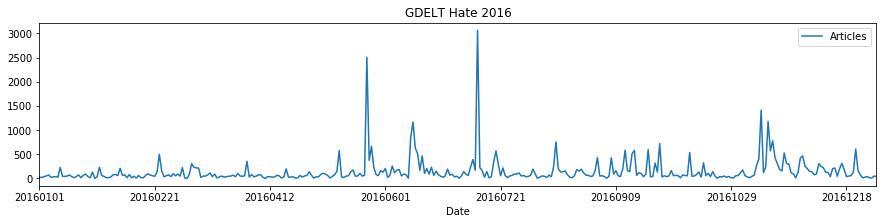

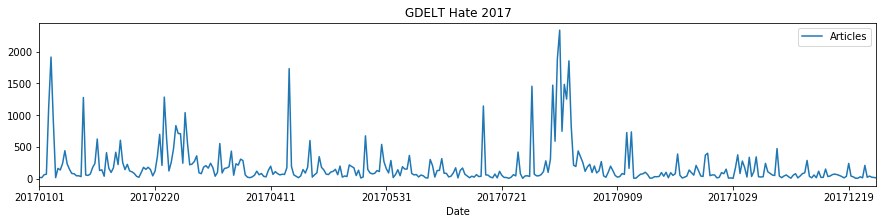

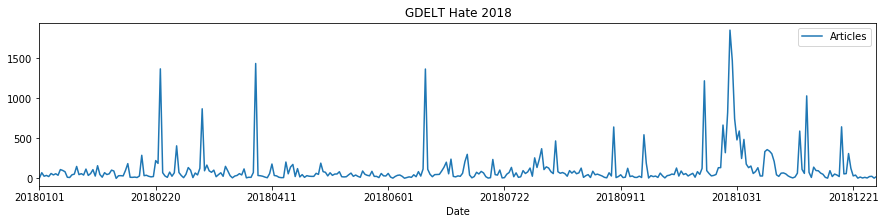

In [28]:
for year in [2016, 2017, 2018]:
    
    cur.execute('''
                select sqldate, sum(numarticles) 
                from gdelt_hate
                where left(sqldate, 4)::integer = {0}
                group by sqldate order by sqldate
                '''.format(year))
    
    h_df = pd.DataFrame([r for r in cur.fetchall()], columns=['Date', 'Articles'])
    h_df.plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Hate {}'.format(year))
    


## Explore "Event Windows" Over Time

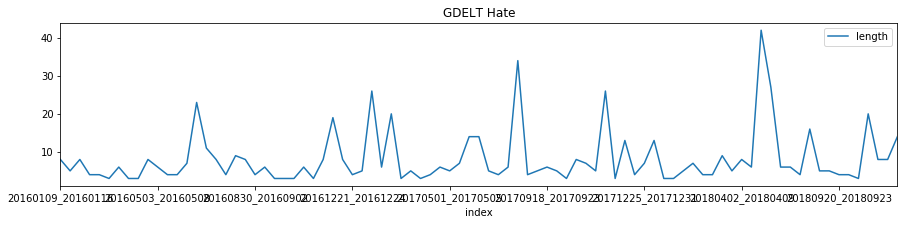

In [4]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()
df.reset_index().plot(x='index', y='length', title='GDELT Hate', figsize=(15, 3))

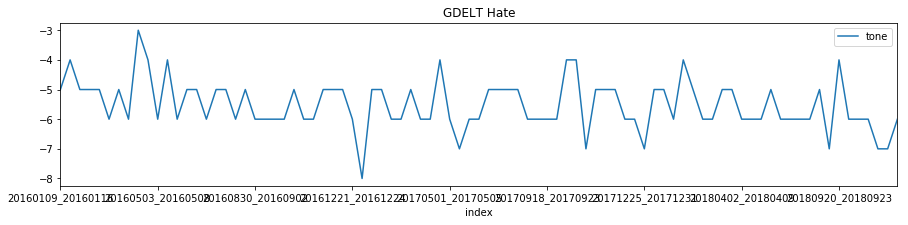

In [5]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()
df.reset_index().plot(x='index', y='tone', title='GDELT Hate', figsize=(15, 3))

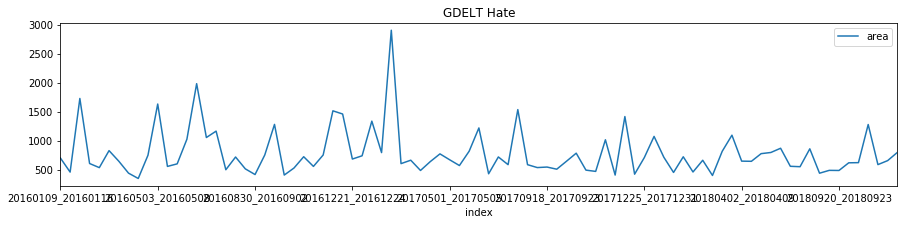

In [6]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()
df.reset_index().plot(x='index', y='area', title='GDELT Hate', figsize=(15, 3))

## Clean & Export "Window" Overview

In [7]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()

a_1 = df['actor_one'].apply(pd.Series)
a_1 = a_1.rename(columns = lambda x : 'a1_' + str(x))
df  = pd.concat([df[:], a_1[:]], axis=1)

a_2 = df['actor_two'].apply(pd.Series)
a_2 = a_2.rename(columns = lambda x : 'a2_' + str(x))
df  = pd.concat([df[:], a_2[:]], axis=1)

keys = df['keywords'].apply(pd.Series)
keys = keys.rename(columns = lambda x : 'k_' + str(x))
df  = pd.concat([df[:], keys[:]], axis=1)

df.reset_index(inplace=True)
df.rename(index=str, columns={"index": "start_end"}, inplace=True)

df['start'] = df['start_end'].apply(lambda x: x[:8])
df['end']   = df['start_end'].apply(lambda x: x[-8:])
df['year']  = df['start_end'].apply(lambda x: x[:4])

df['articles'] = df['articles'].astype('int64')
df['length']   = df['length'].astype('int64')
df['area']     = df['area'].astype('int64')
df['tone']     = df['tone'].astype('int64')

df.head()

,start_end,actor_one,actor_two,area,articles,keywords,length,tone,a1_0,a1_1,...,a2_3,a2_4,k_0,k_1,k_2,k_3,k_4,start,end,year
0,20160109_20160116,"[CRIMINAL, ISLAMIC, ATTORNEY, AFRICA, KANSAS C...","[IRAN, SUICIDE BOMBER, CITIZEN, MEDIA, GANG]",707,519,"[told, muslims, muslim, arrested, terrorist]",8,-5,CRIMINAL,ISLAMIC,...,MEDIA,GANG,told,muslims,muslim,arrested,terrorist,20160109,20160116,2016
1,20160127_20160131,"[STUDENT, MEDIA, CATHOLIC, LAWYER, MUSLIM]","[CRIMINAL, CALIFORNIA, MEDIA, NEIGHBORHOOD, MU...",464,387,"[sexual, law, gay, state, victims]",5,-4,STUDENT,MEDIA,...,NEIGHBORHOOD,MUSLIM,sexual,law,gay,state,victims,20160127,20160131,2016
2,20160202_20160209,"[CRIMINAL, ATTORNEY, STUDENT, SCHOOL, AFRICA]","[MINIST, TROOPER, CRIMINAL, ENTREPRENEUR, NETH...",1733,619,"[muslims, obama, muslim, mosque, state]",8,-5,CRIMINAL,ATTORNEY,...,ENTREPRENEUR,NETHERLANDS,muslims,obama,muslim,mosque,state,20160202,20160209,2016
3,20160217_20160220,"[ATTORNEY, STUDENT, UNITED KINGDOM, UPRISING, ...","[CRIMINAL, ATTORNEY, PROSECUTOR, MEDIA, SPOKES...",612,286,"[law, bill, center, poverty, southern]",4,-5,ATTORNEY,STUDENT,...,MEDIA,SPOKESMAN,law,bill,center,poverty,southern,20160217,20160220,2016
4,20160222_20160225,"[JEWISH, AFRICA, ADVOCATE, EXTREMIST, TOURIST]","[IRAQ, CRIMINAL, CANADIAN, ISLAMIC, STUDENT]",541,828,"[told, black, students, man, bill]",4,-5,JEWISH,AFRICA,...,ISLAMIC,STUDENT,told,black,students,man,bill,20160222,20160225,2016


## 2017 - Average Articles / Event Length

In [8]:
df.groupby('year').agg(['mean', 'max', 'min', 'count'])

area                      articles                      length  \
            mean   max  min count         mean    max  min count      mean   
year                                                                         
2016  839.967742  1988  354    31  1338.387097   7490  259    31  6.548387   
2017  806.533333  2909  413    30  2019.900000  17702  188    30  8.766667   
2018  700.807692  1284  406    26  1341.846154   8782  119    26  9.192308   

                        tone                
     max min count      mean max min count  
year                                        
2016  23   3    31 -5.258065  -3  -6    31  
2017  34   3    30 -5.633333  -4  -8    30  
2018  42   3    26 -5.692308  -4  -7    26

## Unique Keywords

In [9]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'a1_0', 'a1_1', 'a1_2', 'a1_3', 'a1_4', 'a2_0', 'a2_1', 'a2_2', 'a2_3', 'a2_4'
]]

year_df.groupby(['year']).nunique()

,year,k_0,k_1,k_2,k_3,k_4,a1_0,a1_1,a1_2,a1_3,a1_4,a2_0,a2_1,a2_2,a2_3,a2_4
year,,,,,,,,,,,,,,,,
2016,1,22,25,29,28,30,19,19,21,16,23,16,21,24,25,20
2017,1,20,24,27,26,28,25,21,18,18,21,22,21,22,21,22
2018,1,18,19,23,22,24,18,16,18,16,21,22,18,19,23,18


## Most Common Keywords

In [10]:
gb = df.groupby(['year', 'k_0'], as_index=False).count()
gb.sort_values('start', inplace=True, ascending=False)
gb = gb[['year', 'k_0', 'start']]
gb[gb.start > 1]

,year,k_0,start
59,2018,white,6
18,2016,white,6
41,2017,white,6
49,2018,man,4
30,2017,man,3
35,2017,speech,2
34,2017,shooting,2
8,2016,man,2
9,2016,muslim,2
11,2016,officers,2


In [11]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'articles'
]]

year_df.groupby(['year']).agg(['sum'])
year_df.sort_values(['articles', 'year'], ascending=False).head(n=20)

,year,k_0,k_1,k_2,k_3,k_4,articles
47,2017,white,charlottesville,violence,rally,speech,17702
34,2017,shooting,jewish,threats,community,kansas,9365
83,2018,synagogue,shooting,pittsburgh,jewish,man,8782
28,2016,election,white,incidents,muslims,state,7490
32,2017,man,muslim,law,speech,federal,5856
14,2016,orlando,shooting,violence,attack,gay,5288
15,2016,officers,lives,black,dallas,white,4627
31,2017,chicago,man,victim,suspects,video,4027
13,2016,bill,lives,matter,blue,law,3984
73,2018,men,dont,white,man,speech,3484


In [12]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'articles'
]]

year_df.groupby(['year', 'k_0', 'k_1', 'k_3', 'k_4']).sum()

articles
year k_0       k_1           k_3             k_4                   
2016 bill      lives         blue            law               3984
     center    state         islam           muslims           1083
     church    ad            couple          letter             259
     clinton   hillary       hurricane       live               753
     election  white         muslims         state             7490
     iowa      students      black           university         389
     islamic   letter        incidents       reported          1847
     law       bill          poverty         southern           286
     man       hateful       ohio            appeal             356
               women         law             blue               821
     muslim    set           mosque          man                955
               state         woman           york               987
     muslims   obama         mosque          state              619
     officers  law           baton           2020              1593
               lives         dallas          white             4627
     orlando   shooting      attack          gay               5288
     school    charges       boy             told               831
     sexual    law           state           victims            387
     speech    iowa          student         city               417
     student   bill          asia            education          428
     told      black         man             bill               828
               muslims       arrested        terrorist          519
     white     lives         movement        splc               699
               man           clinton         hillary            878
                                             khalsa             638
               protesters    charlotte       congressman        728
               told          man             dont               410
               york          folsom          onby               884
     women     mosque        charged         hatecrime          284
     world     republican    debate          fox                443
...                                                             ...
2017 white     resolution    charlottesville condemning        1687
               school        student         fbi               3169
               speech        racist          antisemitism       466
               university    speech          iowa               341
2018 alex      infowars      austin          cair               754
     black     man           star            carothers          763
     brutal    gay           oic             25                 119
     charged   reported      county          man                336
     dont      conservatives free            know               316
     jabara    man           white           family             300
     law       media         2017            speech             683
     man       called        daily           beckham            334
               law           state           york               287
               media         border          curiel             589
               white         york            political         1442
     men       dont          man             speech            3484
     mosque    man           texas           perez              449
     muslim    san           aghdam          company           1647
     oklahoma  convicted     jabara          majors             212
     pleads    purinton      kansas          murder             301
     say       house         white           bonner             252
     speech    copyright     haters          lyrics             422
     state     white         itthe           late              1971
     synagogue shooting      jewish          man               8782
     white     man           law             reported          1660
                             state           life              2396
               speech        man             bl

In [13]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'articles'
]]

year_df.groupby(['year']).sum()
year_df.sort_values('articles', ascending=False)

,year,k_0,k_1,k_2,k_3,k_4,articles
47,2017,white,charlottesville,violence,rally,speech,17702
34,2017,shooting,jewish,threats,community,kansas,9365
83,2018,synagogue,shooting,pittsburgh,jewish,man,8782
28,2016,election,white,incidents,muslims,state,7490
32,2017,man,muslim,law,speech,federal,5856
14,2016,orlando,shooting,violence,attack,gay,5288
15,2016,officers,lives,black,dallas,white,4627
31,2017,chicago,man,victim,suspects,video,4027
13,2016,bill,lives,matter,blue,law,3984
73,2018,men,dont,white,man,speech,3484


In [14]:
events = json.load(open('gdelt_hate.json', 'rb'))
total_events = len(events.keys())

white_count = 0
white_count_length = []

man_count = 0
man_count_length = []

black_count = 0
black_count_length = []

muslim_count = 0
muslim_count_length = []

other_length = []

for event, attributes in events.items():
    if 'white' in attributes['keywords']:    
        white_count += 1
        white_count_length.append(attributes['length'])
        
    elif 'black' in attributes['keywords']:
        black_count += 1
        black_count_length.append(attributes['length'])
        
    elif 'muslim' in attributes['keywords'] or 'muslims' in attributes['keywords']:
        muslim_count += 1
        muslim_count_length.append(attributes['length'])
        
    elif 'man' in attributes['keywords']:
        man_count += 1
        man_count_length.append(attributes['length'])
        
    else:
        other_length.append(attributes['length'])
        

print(f'White Percent of All Events: {round((white_count / total_events) * 100)}')
print(f'Average White Event Length: {round(np.mean(white_count_length))}')
print('#' * 50)
print(f'Man Percent of All Events: {round((man_count / total_events) * 100)}')
print(f'Average Man Event Length: {round(np.mean(man_count_length))}')
print('#' * 50)
print(f'Muslim Percent of All Events: {round((muslim_count / total_events) * 100)}')
print(f'Average Muslim Event Length: {round(np.mean(muslim_count_length))}')
print('#' * 50)
print(f'Black Percent of All Events: {round((black_count / total_events) * 100)}')
print(f'Average Black Event Length: {round(np.mean(black_count_length))}')
print('#' * 50)
print(f'Average Event Length: {round(np.mean(black_count_length))}')

White Percent of All Events: 38
Average White Event Length: 10.0
##################################################
Man Percent of All Events: 13
Average Man Event Length: 8.0
##################################################
Muslim Percent of All Events: 14
Average Muslim Event Length: 9.0
##################################################
Black Percent of All Events: 5
Average Black Event Length: 5.0
##################################################
Average Event Length: 5.0


In [15]:
all_keys = list(chain(*[k['keywords'] for k in events.values()]))
count = Counter(all_keys).most_common(15)
count

[('white', 33),
 ('man', 31),
 ('speech', 16),
 ('state', 13),
 ('law', 12),
 ('muslim', 10),
 ('york', 7),
 ('muslims', 6),
 ('mosque', 6),
 ('black', 6),
 ('university', 6),
 ('bill', 5),
 ('student', 5),
 ('murder', 5),
 ('told', 4)]